In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!apt-get install -y fonts-nanum

# NanumGothic 폰트를 Matplotlib의 기본 폰트로 설정
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')


In [ ]:
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/KOPIS/블루스퀘어/트레이닝_데이터(라벨인코딩).xlsx')
test_df = pd.read_excel('/content/drive/MyDrive/KOPIS/블루스퀘어/테스트_데이터(라벨인코딩).xlsx')


In [ ]:
df

,전송사업자코드,예매/취소방식코드,결제수단코드,할인금액,할인종류코드,장당금액,성별,판매좌석수,예매후남은일자,취소여부,연도,월,일,주말여부,공휴일여부,노인,청년,성인,좌석등급
0,1,0,1,0,1,161500,2,1309,33,0,2023,10,1,1,0,0,0,1,3
1,1,0,1,0,1,161500,2,1309,33,0,2023,10,1,1,0,0,0,1,3
2,1,0,1,0,1,161500,1,1309,33,0,2023,10,1,1,0,0,0,1,3
3,1,0,1,0,1,161500,2,1309,32,1,2023,10,1,1,0,0,0,1,3
4,1,0,1,0,1,161500,1,1309,33,1,2023,10,1,1,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284595,1,1,1,0,1,76000,2,1309,0,0,2023,8,31,0,0,0,0,1,0
284596,1,1,1,0,1,76000,2,1309,0,0,2023,8,31,0,0,0,0,1,0
284597,1,1,1,0,1,80000,1,1309,0,0,2023,8,31,0,0,0,0,1,0
284598,1,1,1,0,1,133000,1,1309,0,0,2023,8,31,0,0,0,1,0,1


## 1. catboost 모델링

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

# Target 변수와 Feature 변수 설정
X = df.drop(columns=['취소여부'])
y = df['취소여부']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 2. 상위 피처 셀렉션

In [ ]:
!pip install catboost

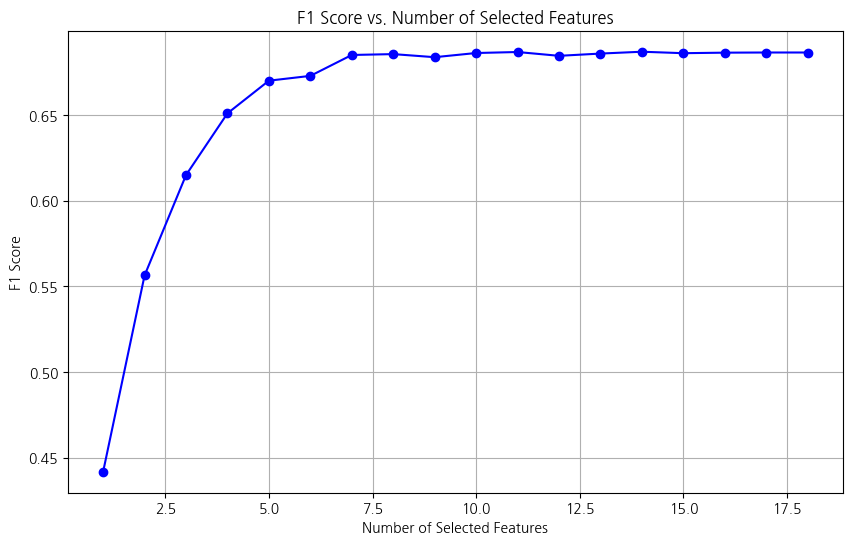

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

# CatBoost 모델을 이용해 피처 중요도 계산
model = CatBoostClassifier(random_state=42, verbose=0)  # verbose=0으로 설정하여 학습 로그를 숨깁니다.
model.fit(X_train, y_train)
feature_importances = model.get_feature_importance()

# 피처 중요도에 따른 상위 n개 피처를 선택하고, F1 스코어를 비교
f1_scores = []
feature_counts = list(range(1, X_train.shape[1] + 1))

for n_top_features in feature_counts:
    # 상위 n개 피처 선택
    important_features = X_train.columns[np.argsort(feature_importances)[-n_top_features:]]

    # 선택된 피처만 사용하여 데이터셋 구성
    X_train_selected = X_train[important_features]
    X_test_selected = X_test[important_features]

    # 모델 학습 및 평가
    model_selected = CatBoostClassifier(random_state=42, verbose=0)
    model_selected.fit(X_train_selected, y_train)
    y_pred_selected = model_selected.predict(X_test_selected)

    # F1 스코어 계산
    f1 = f1_score(y_test, y_pred_selected)
    f1_scores.append(f1)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, f1_scores, marker='o', color='blue')
plt.xlabel('Number of Selected Features')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Number of Selected Features')
plt.grid(True)
plt.show()


## 3. feature importance 시각화

<ipython-input-9-d8e05436c1a4>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features_top, y=features_top.index, palette='viridis')


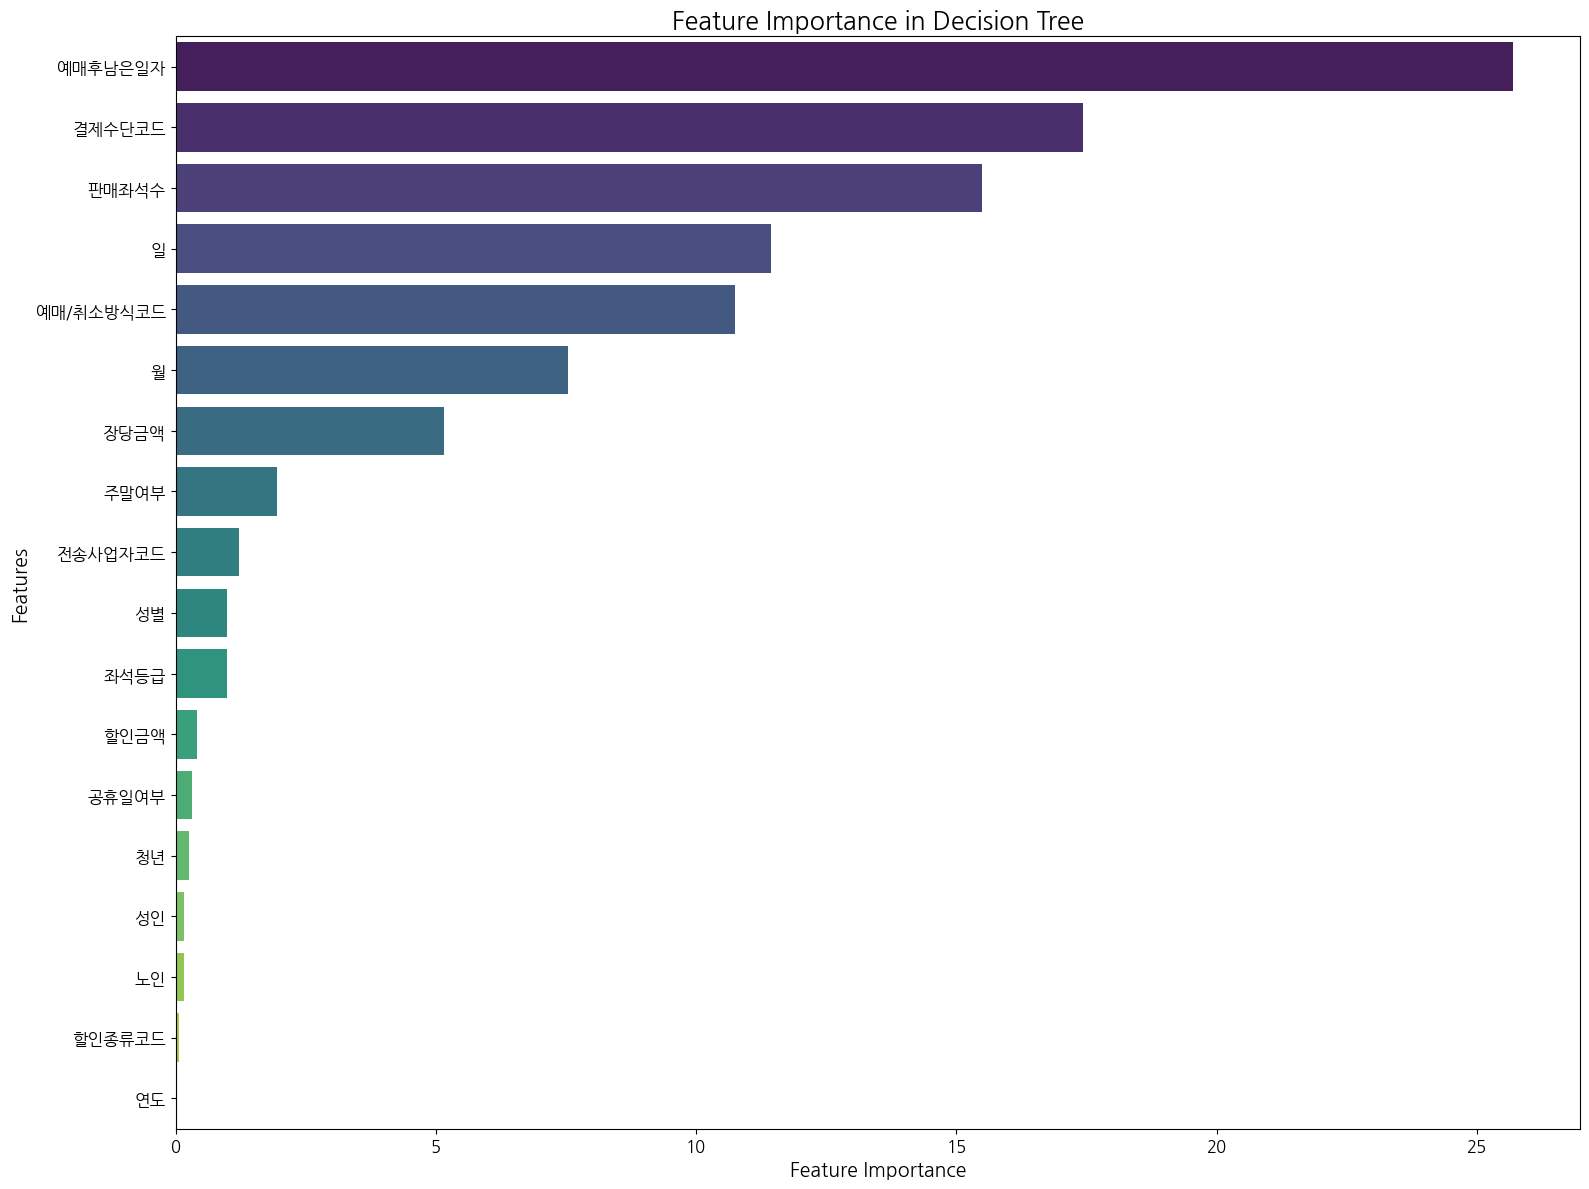

In [ ]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# Feature Importance 시각화
features_importance = model.feature_importances_
features_importance = pd.Series(features_importance, index=X_train.columns)
features_top = features_importance.sort_values(ascending=False)

plt.figure(figsize=(16, 12))
plt.title('Feature Importance in Decision Tree', fontsize=18)
sns.barplot(x=features_top, y=features_top.index, palette='viridis')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # 레이아웃 조정
plt.show()

In [ ]:
# 최고의 성능을 보이는 n값(feature 개수) 찾기
best_n = feature_counts[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"최고의 성능을 보이는 n값: {best_n}")
print(f"최고 F1 스코어: {best_f1_score}")

최고의 성능을 보이는 n값: 14
최고 F1 스코어: 0.6871374696096637


### 4. catboost 하이퍼파라미터 튜닝 (시용완료)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from catboost import CatBoostClassifier
# from sklearn.metrics import f1_score, classification_report
# from sklearn.model_selection import train_test_split, RandomizedSearchCV

# # 최적의 n값으로 상위 14개 피처 선택
# model = CatBoostClassifier(random_state=42, verbose=0)  # verbose=0으로 설정하여 학습 로그를 숨깁니다.
# model.fit(X_train, y_train)
# feature_importances = model.get_feature_importance()
# important_features = X_train.columns[np.argsort(feature_importances)[-14:]]

# # 선택된 피처만 사용하여 데이터셋 구성
# X_train_selected = X_train[important_features]
# X_test_selected = X_test[important_features]

# # 하이퍼파라미터 검색을 위한 파라미터 그리드 설정
# param_grid = {
#     'iterations': [500, 1000, 1500],
#     'depth': [3, 4, 6, 8, 10, 12],
#     'learning_rate': [0.01, 0.03, 0.05, 0.1],
#     'l2_leaf_reg': [1, 3, 5, 7, 9, 11],
#     'bagging_temperature': [0.5, 1, 2],
#     'random_strength': [0.5, 1, 2, 5],
#     'border_count': [16, 32, 64, 128],
#     'scale_pos_weight': [0.5, 1, 2, 5, 10]
# }

# # RandomizedSearchCV를 사용한 하이퍼파라미터 튜닝
# randomized_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=5, scoring='f1', n_jobs=-1, random_state=42, verbose=2)
# randomized_search.fit(X_train_selected, y_train)

# # 최적의 하이퍼파라미터와 성능 출력
# print(f"최적의 하이퍼파라미터: {randomized_search.best_params_}")
# print(f"최고의 F1 스코어: {randomized_search.best_score_}")


### Best Hyperparameters:{'scale_pos_weight': 2, 'random_strength': 2, 'learning_rate': 0.05, 'l2_leaf_reg': 11, 'iterations': 1500, 'depth': 12, 'border_count': 128, 'bagging_temperature': 1}

최고의 F1 스코어: 0.7355089900860607

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Target 변수와 Feature 변수 설정
X = df.drop(columns=['취소여부'])
y = df['취소여부']

# Train-Test Split (모델 평가를 위해 테스트 데이터셋이 필요함)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 최적의 n값으로 상위 14개 피처 선택
model = CatBoostClassifier(random_state=42, verbose=0)  # verbose=0으로 설정하여 학습 로그를 숨깁니다.
model.fit(X_train, y_train)
feature_importances = model.get_feature_importance()
important_features = X_train.columns[np.argsort(feature_importances)[-14:]]

# 선택된 피처만 사용하여 데이터셋 구성
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

# 최적의 하이퍼파라미터로 모델 학습
best_params = {
    'scale_pos_weight': 2,
    'random_strength': 2,
    'learning_rate': 0.05,
    'l2_leaf_reg': 11,
    'iterations': 1500,
    'depth': 12,
    'border_count': 128,
    'bagging_temperature': 1
}

best_catboost = CatBoostClassifier(**best_params, random_state=42, verbose=0)
best_catboost.fit(X_train_selected, y_train)


Train Accuracy: 0.7543
Train F1 Score: 0.7829
Train Precision: 0.6743
Train Recall: 0.9332

Train Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.59      0.72    119564
           1       0.67      0.93      0.78    108116

    accuracy                           0.75    227680
   macro avg       0.79      0.76      0.75    227680
weighted avg       0.80      0.75      0.75    227680



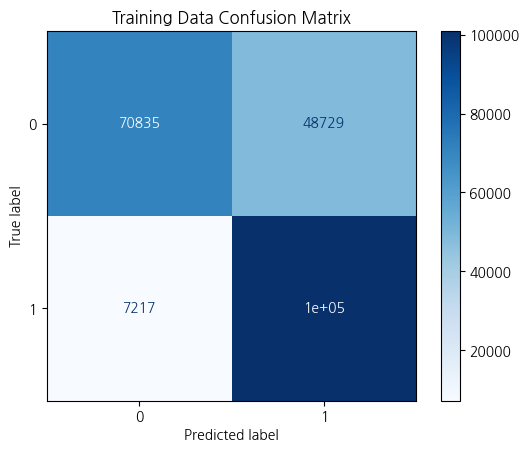

In [ ]:
# 트레이닝 데이터에서 성능 평가
train_pred = best_catboost.predict(X_train_selected)
train_accuracy = accuracy_score(y_train, train_pred)
train_f1 = f1_score(y_train, train_pred)
train_precision = precision_score(y_train, train_pred)
train_recall = recall_score(y_train, train_pred)
train_classification_rep = classification_report(y_train, train_pred)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Train F1 Score: {train_f1:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')
print('\nTrain Classification Report:\n', train_classification_rep)

# 혼동 행렬 계산 (트레이닝 데이터)
conf_matrix_train = confusion_matrix(y_train, train_pred)

# 혼동 행렬 시각화 (트레이닝 데이터)
disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Training Data Confusion Matrix")
plt.show()


Test Accuracy: 0.7008
Test F1 Score: 0.7349
Test Precision: 0.6303
Test Recall: 0.8812

Test Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.54      0.66     30126
           1       0.63      0.88      0.73     26794

    accuracy                           0.70     56920
   macro avg       0.73      0.71      0.70     56920
weighted avg       0.74      0.70      0.69     56920



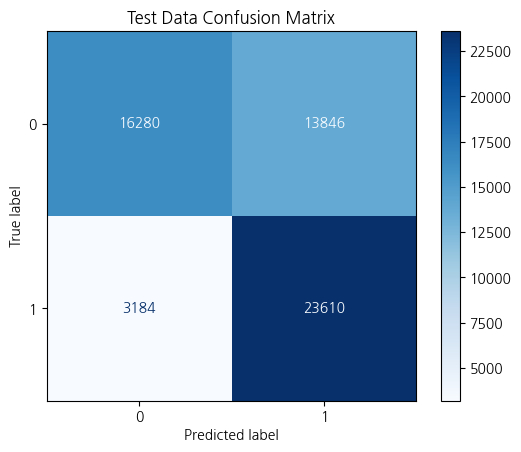

In [ ]:
# 테스트 데이터에서 성능 평가
test_pred = best_catboost.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred)
test_precision = precision_score(y_test, test_pred)
test_recall = recall_score(y_test, test_pred)
test_classification_rep = classification_report(y_test, test_pred)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print('\nTest Classification Report:\n', test_classification_rep)

# 혼동 행렬 계산 (테스트 데이터)
conf_matrix_test = confusion_matrix(y_test, test_pred)

# 혼동 행렬 시각화 (테스트 데이터)
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Test Data Confusion Matrix")
plt.show()


In [ ]:
# 최적의 하이퍼파라미터로 학습된 모델 저장
import joblib

model_filename = '/content/drive/MyDrive/KOPIS/블루스퀘어/best_catboost_model.pkl'
joblib.dump(best_catboost, model_filename)

print(f"모델이 '{model_filename}'에 저장되었습니다.")


모델이 '/content/drive/MyDrive/KOPIS/블루스퀘어/best_catboost_model.pkl'에 저장되었습니다.
